In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, RepeatedStratifiedKFold, learning_curve, validation_curve, GridSearchCV, train_test_split, cross_val_score, cross_validate, RepeatedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import power_transform, FunctionTransformer, StandardScaler, MinMaxScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, make_scorer, mean_squared_error, r2_score
from scipy.stats import pearsonr
import requests
import zipfile
import io
import pydotplus
from sklearn import tree
from IPython.display import Image
import joblib
import warnings
from sklearn.exceptions import ConvergenceWarning

# Para manejar warnings
import functools




# Obtención de los datos del Banco Mundial


In [ ]:


# Función para obtener datos de la API del Banco Mundial
def fetch_world_bank_data(indicator, countries="all", start_year=2000, end_year=2020):
    url = f"http://api.worldbank.org/v2/country/{countries}/indicator/{indicator}?date={start_year}:{end_year}&format=json&per_page=20000"
    response = requests.get(url)
    data = response.json()
    
    if len(data) == 2:
        # Extraer el nombre del país del diccionario
        for record in data[1]:
            if 'country' in record and 'value' in record['country']:
                record['country'] = record['country']['value']
        
        df = pd.DataFrame(data[1])
        df = df[['country', 'date', 'value']]
        df.columns = ['Country', 'Year', indicator]
        df['Year'] = df['Year'].astype(int)
        return df
    else:
        print(f"Error fetching data for {indicator}")
        return None

# Indicadores a descargar
indicators = {
    'Renewable energy consumption (% of total final energy consumption)': 'EG.FEC.RNEW.ZS',
    'CO2 emissions from solid fuel consumption (kt)': 'EN.ATM.CO2E.SF.KT',
    'Literacy rate, adult total (% of people ages 15 and above)': 'SE.ADT.LITR.ZS',
    'GDP (current US$)': 'NY.GDP.MKTP.CD'
}

# Descargar datos
data_frames = []
for name, code in indicators.items():
    df = fetch_world_bank_data(code)
    if df is not None:
        df = df.rename(columns={code: name})
        data_frames.append(df)

# Unir los datos en un solo DataFrame
final_df = data_frames[0]
for df in data_frames[1:]:
    final_df = pd.merge(final_df, df, on=['Country', 'Year'], how='outer')

# Limpieza de datos
final_df.dropna(inplace=True)

# Mostrar un resumen de los datos
print(final_df.describe())


Podría tener problemas al momento de obtener la información, durante la semana estuvo funcionando sin problema pero en el fin de semana la API del banco mundial dejo de funcionar, favor de contarme si el problema persiste.

In [2]:
display(final_df)

,Country,Year,Renewable energy consumption (% of total final energy consumption),CO2 emissions from solid fuel consumption (kt),"Literacy rate, adult total (% of people ages 15 and above)",GDP (current US$)
4,Africa Eastern and Southern,2016,62.457688,605867.346840,71.095200,8.298300e+11
5,Africa Eastern and Southern,2015,62.128338,587353.836150,70.313423,8.992957e+11
6,Africa Eastern and Southern,2014,61.499577,626313.761249,69.834770,9.796897e+11
7,Africa Eastern and Southern,2013,61.082685,593205.503573,69.383102,9.633473e+11
8,Africa Eastern and Southern,2012,61.718397,594031.621327,68.361351,9.526756e+11
...,...,...,...,...,...,...
5554,Zambia,2010,89.200000,381.368000,83.007668,2.026556e+10
5557,Zambia,2007,90.700000,293.360000,61.127090,1.405696e+10
5562,Zambia,2002,89.600000,304.361000,69.149223,4.193850e+09
5571,Zimbabwe,2014,80.800000,7737.370000,88.693420,1.949552e+10


In [3]:
distinct_countries = final_df['Country'].unique()
display(distinct_countries)

array(['Africa Eastern and Southern', 'Africa Western and Central',
       'Central Europe and the Baltics', 'Early-demographic dividend',
       'East Asia & Pacific',
       'East Asia & Pacific (excluding high income)',
       'East Asia & Pacific (IDA & IBRD countries)',
       'Europe & Central Asia',
       'Europe & Central Asia (excluding high income)',
       'Europe & Central Asia (IDA & IBRD countries)',
       'Fragile and conflict affected situations', 'IBRD only',
       'IDA & IBRD total', 'IDA blend', 'IDA total',
       'Late-demographic dividend', 'Latin America & Caribbean',
       'Latin America & Caribbean (excluding high income)',
       'Latin America & the Caribbean (IDA & IBRD countries)',
       'Low & middle income', 'Lower middle income',
       'Middle East & North Africa (excluding high income)',
       'Middle East & North Africa (IDA & IBRD countries)',
       'Middle income', 'North America', 'South Asia',
       'South Asia (IDA & IBRD)', 'Sub-Saharan 

Relación entre la variable de CO2 y consumo de energia renovable

## Análisis de las variables y limpieza

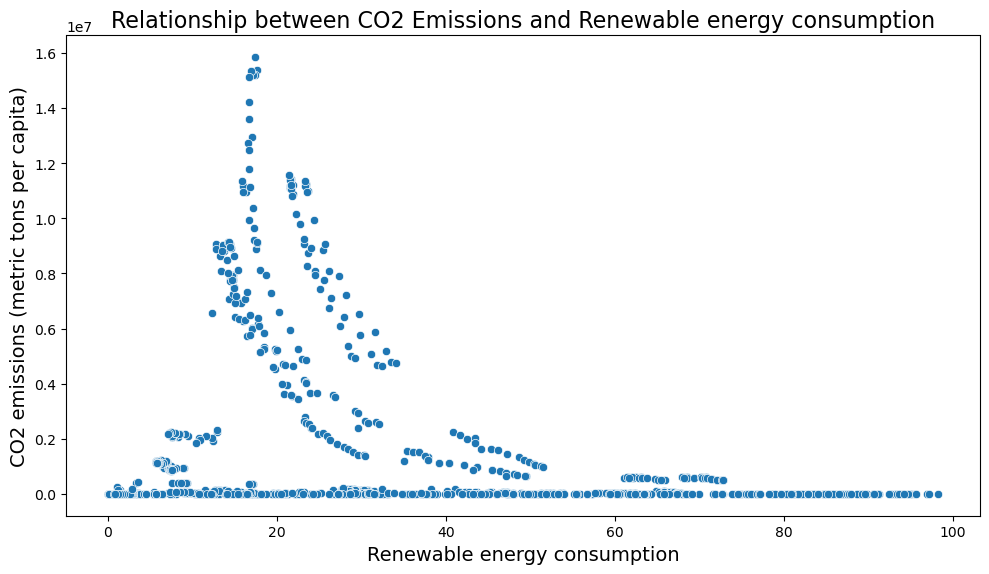

In [7]:


# Establecer el estilo de Seaborn
sns.set_theme=("whitegrid")

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Renewable energy consumption (% of total final energy consumption)', y='CO2 emissions from solid fuel consumption (kt)', data=final_df)

# Establecer escala logarítmica en el eje X si los datos están muy dispersos
#plt.xscale('log')

# Agregar títulos y etiquetas
plt.title('Relationship between CO2 Emissions and Renewable energy consumption', fontsize=16)
plt.xlabel('Renewable energy consumption', fontsize=14)
plt.ylabel('CO2 emissions (metric tons per capita)', fontsize=14)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Este gráfico muestra cómo se relacionan las emisiones de CO2 y el consumo de energía renovable. Lo que se ve es que en lugares donde se usa poca energía renovable (menos del 20% del total), las emisiones de CO2 pueden ser bastante altas. Pero, a medida que más energía proviene de fuentes renovables, las emisiones de CO2 empiezan a bajar. De hecho, casi no hay emisiones altas cuando el consumo de energía renovable supera el 60%.

Parece que si un país o región le apuesta más a las energías limpias, logran reducir bastante sus emisiones de CO2. Aunque no es una regla exacta para todos, el gráfico sugiere que irse por las renovables es un buen camino para cuidar el medio ambiente.

La data tiene cierta suciedad por lo que debemos limpiarla

In [15]:
# Seleccionar solo las columnas deseadas
selected_columns = ['Renewable energy consumption (% of total final energy consumption)', 
                    'CO2 emissions from solid fuel consumption (kt)']

# Crear una copia del DataFrame con solo esas columnas
df_selected = final_df[selected_columns].copy()

# Verificar el nuevo DataFrame
print(df_selected.head())


   Renewable energy consumption (% of total final energy consumption)  \
4                                          62.457688                    
5                                          62.128338                    
6                                          61.499577                    
7                                          61.082685                    
8                                          61.718397                    

   CO2 emissions from solid fuel consumption (kt)  
4                                   605867.346840  
5                                   587353.836150  
6                                   626313.761249  
7                                   593205.503573  
8                                   594031.621327  


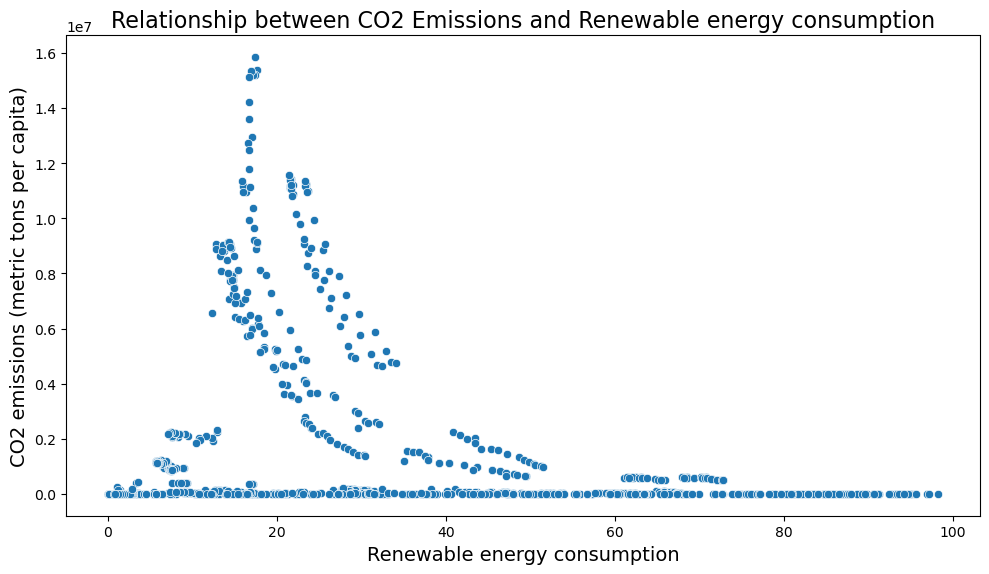

In [16]:


# Establecer el estilo de Seaborn
sns.set_theme=("whitegrid")

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Renewable energy consumption (% of total final energy consumption)', y='CO2 emissions from solid fuel consumption (kt)', data=df_selected)

# Establecer escala logarítmica en el eje X si los datos están muy dispersos
#plt.xscale('log')

# Agregar títulos y etiquetas
plt.title('Relationship between CO2 Emissions and Renewable energy consumption', fontsize=16)
plt.xlabel('Renewable energy consumption', fontsize=14)
plt.ylabel('CO2 emissions (metric tons per capita)', fontsize=14)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Realizamos una copia de la data, y ploteamos el resultado

In [24]:
# Filtrar los datos que cumplen la condición
df_filtered_renewable = df_selected[df_selected['Renewable energy consumption (% of total final energy consumption)'].between(0, 45)]

# Mostrar los datos filtrados
display(df_filtered_renewable)


,Renewable energy consumption (% of total final energy consumption),CO2 emissions from solid fuel consumption (kt)
88,16.872230,3.420468e+05
89,17.145034,3.445220e+05
90,17.080062,3.467222e+05
91,16.667886,3.671034e+05
109,23.295071,2.807075e+06
...,...,...
5448,14.800000,7.774040e+02
5450,16.200000,8.617450e+02
5452,16.600000,4.033700e+02
5458,14.000000,1.760160e+02


In [26]:
df_filtered_renewable.describe()

,Renewable energy consumption (% of total final energy consumption),CO2 emissions from solid fuel consumption (kt)
count,604.000000,6.040000e+02
mean,18.987048,2.533100e+06
std,11.710377,3.759300e+06
min,0.100000,3.667000e+00
25%,9.041704,2.256213e+04
50%,17.178341,1.734069e+05
75%,28.776554,4.540673e+06
max,44.900000,1.584490e+07


Eliminamos los datos que podrían ocasionar ruido en el analisis y modelado

In [28]:

import numpy as np
# Aplicar la condición para eliminar solo los valores de CO2 sin filtrar Renewable energy
df_selected.loc[(df_selected['CO2 emissions from solid fuel consumption (kt)'] < 1000000) &
                (df_selected['Renewable energy consumption (% of total final energy consumption)'].between(0, 45)),
                'CO2 emissions from solid fuel consumption (kt)'] = np.nan

# Eliminar las filas que ahora contienen NaN en la columna de CO2 (opcional)
df_selected.dropna(subset=['CO2 emissions from solid fuel consumption (kt)'], inplace=True)

# Verificar los datos modificados
print(df_selected.describe())



       Renewable energy consumption (% of total final energy consumption)  \
count                                         597.000000                    
mean                                           47.458777                    
std                                            26.194248                    
min                                             5.636369                    
25%                                            21.639674                    
50%                                            49.419869                    
75%                                            69.319905                    
max                                            98.300000                    

       CO2 emissions from solid fuel consumption (kt)  
count                                    5.970000e+02  
mean                                     2.610006e+06  
std                                      3.744883e+06  
min                                      0.000000e+00  
25%                       

In [23]:
display(df_selected)

,Renewable energy consumption (% of total final energy consumption),CO2 emissions from solid fuel consumption (kt)
4,62.457688,605867.346840
5,62.128338,587353.836150
6,61.499577,626313.761249
7,61.082685,593205.503573
8,61.718397,594031.621327
...,...,...
5554,89.200000,381.368000
5557,90.700000,293.360000
5562,89.600000,304.361000
5571,80.800000,7737.370000


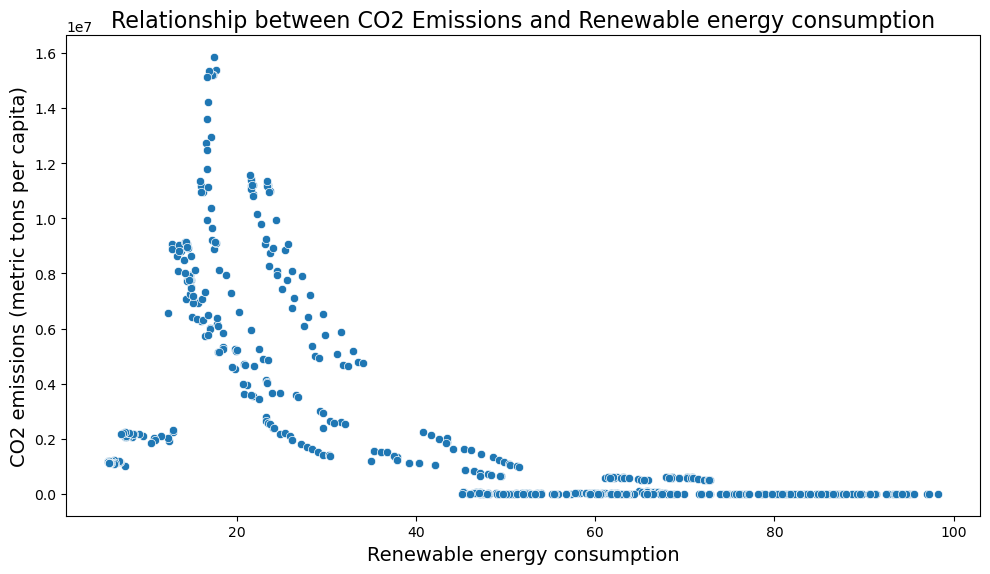

In [29]:


# Establecer el estilo de Seaborn
sns.set_theme=("whitegrid")

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Renewable energy consumption (% of total final energy consumption)', y='CO2 emissions from solid fuel consumption (kt)', data=df_selected)

# Establecer escala logarítmica en el eje X si los datos están muy dispersos
#plt.xscale('log')

# Agregar títulos y etiquetas
plt.title('Relationship between CO2 Emissions and Renewable energy consumption', fontsize=16)
plt.xlabel('Renewable energy consumption', fontsize=14)
plt.ylabel('CO2 emissions (metric tons per capita)', fontsize=14)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Eliminamos los datos que podrían haber brindando ruido en nuestro analisis, podemos observar un mejor patron de la información

In [37]:
from scipy.stats import pearsonr
corr_coefficient, p_value = pearsonr(df_selected['Renewable energy consumption (% of total final energy consumption)'], df_selected['CO2 emissions from solid fuel consumption (kt)'])

Obtenemos la correlación entre las variables

In [39]:
print(corr_coefficient, p_value)

-0.6980865229430896 2.2280071947831984e-88


Al realizar el análisis de correlación, se obtuvo un coeficiente de -0.698, lo cual indica una relación negativa significativa entre las variables de estudio. Este valor sugiere que existe una tendencia consistente en la que, al aumentar una de las variables, la otra tiende a disminuir.

El valor p asociado a esta correlación es extremadamente bajo, prácticamente cero, lo que confirma la significancia estadística del hallazgo. En otras palabras, la probabilidad de que esta correlación haya ocurrido por azar es prácticamente nula, lo que refuerza la solidez del análisis.

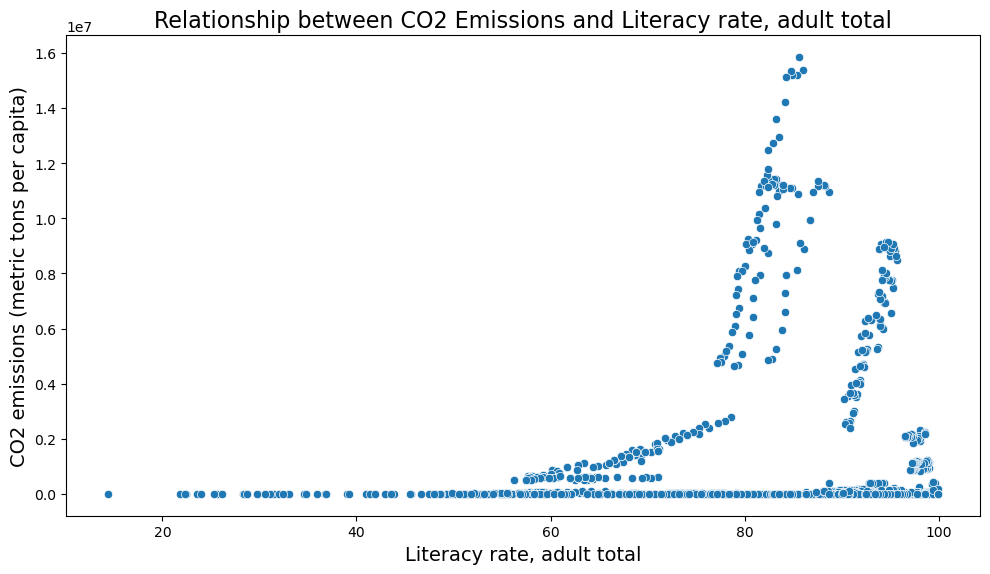

In [10]:


# Establecer el estilo de Seaborn
sns.set_theme=("whitegrid")

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Literacy rate, adult total (% of people ages 15 and above)', y='CO2 emissions from solid fuel consumption (kt)', data=final_df)

# Establecer escala logarítmica en el eje X si los datos están muy dispersos
#plt.xscale('log')

# Agregar títulos y etiquetas
plt.title('Relationship between CO2 Emissions and Literacy rate, adult total', fontsize=16)
plt.xlabel('Literacy rate, adult total', fontsize=14)
plt.ylabel('CO2 emissions (metric tons per capita)', fontsize=14)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

El gráfico sugiere una correlación positiva entre la tasa de alfabetización y las emisiones de CO2 per cápita,la relación no es perfecta y muestra variaciones significativas. Esto podría indicar que, en general, los países más alfabetizados también son los que más emiten CO2, posiblemente debido a un mayor grado de desarrollo económico.
Debemos realiza limpieza a la columna

In [43]:
# Seleccionar solo las columnas deseadas
selected_columns = ['Literacy rate, adult total (% of people ages 15 and above)', 
                    'CO2 emissions from solid fuel consumption (kt)']

# Crear una copia del DataFrame con solo esas columnas
df_selected2 = final_df[selected_columns].copy()

# Verificar el nuevo DataFrame
print(df_selected2.head())

   Literacy rate, adult total (% of people ages 15 and above)  \
4                                          71.095200            
5                                          70.313423            
6                                          69.834770            
7                                          69.383102            
8                                          68.361351            

   CO2 emissions from solid fuel consumption (kt)  
4                                   605867.346840  
5                                   587353.836150  
6                                   626313.761249  
7                                   593205.503573  
8                                   594031.621327  


In [46]:
# Filtrar los datos que cumplen la condición
df_filtered_literacy = df_selected2[df_selected2['Literacy rate, adult total (% of people ages 15 and above)'].between(57,100 )]

# Mostrar los datos filtrados
#display(df_filtered_literacy)

In [47]:
df_filtered_literacy.describe()

,"Literacy rate, adult total (% of people ages 15 and above)",CO2 emissions from solid fuel consumption (kt)
count,975.000000,9.750000e+02
mean,84.065361,1.634316e+06
std,13.228617,3.178405e+06
min,57.093380,0.000000e+00
25%,73.078285,3.391975e+02
50%,89.772583,5.226942e+04
75%,94.635590,1.155115e+06
max,99.994858,1.584490e+07


In [55]:

# Aplicar la condición para eliminar solo los valores de CO2 sin filtrar Renewable energy
df_selected2.loc[(df_selected2['CO2 emissions from solid fuel consumption (kt)'] < 500000) &
                (df_selected2['Literacy rate, adult total (% of people ages 15 and above)'].between(57, 100)),
                'CO2 emissions from solid fuel consumption (kt)'] = np.nan

# Eliminar las filas que ahora contienen NaN en la columna de CO2 (opcional)
df_selected2.dropna(subset=['CO2 emissions from solid fuel consumption (kt)'], inplace=True)

# Verificar los datos modificados
df_selected2.describe()

,"Literacy rate, adult total (% of people ages 15 and above)",CO2 emissions from solid fuel consumption (kt)
count,363.000000,3.630000e+02
mean,74.686459,4.149530e+06
std,21.246945,4.119685e+06
min,14.376040,0.000000e+00
25%,56.165976,1.889238e+04
50%,81.531601,2.237718e+06
75%,93.507710,7.743422e+06
max,99.044769,1.584490e+07


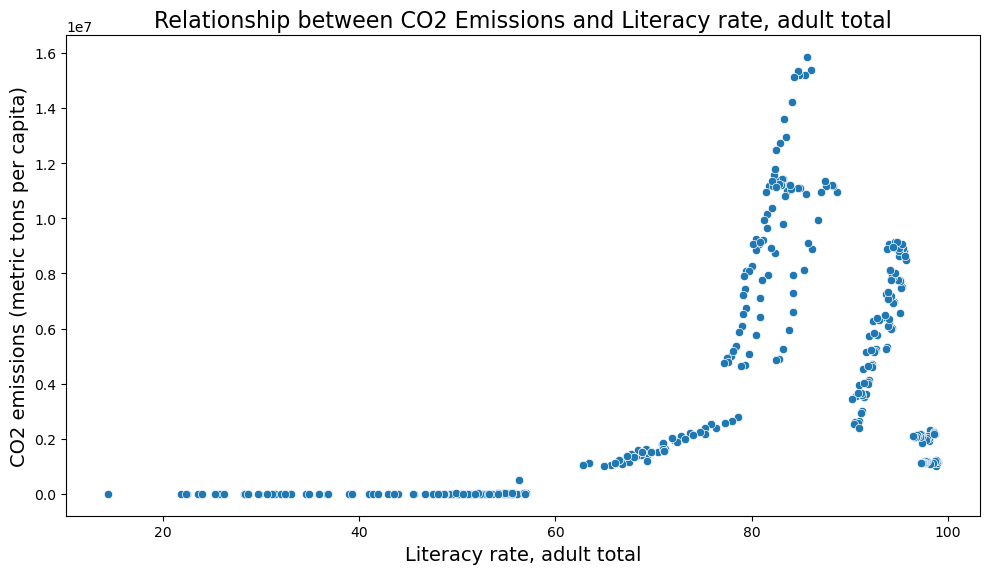

In [56]:


# Establecer el estilo de Seaborn
sns.set_theme=("whitegrid")

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Literacy rate, adult total (% of people ages 15 and above)', y='CO2 emissions from solid fuel consumption (kt)', data=df_selected2)

# Establecer escala logarítmica en el eje X si los datos están muy dispersos
#plt.xscale('log')

# Agregar títulos y etiquetas
plt.title('Relationship between CO2 Emissions and Literacy rate, adult total', fontsize=16)
plt.xlabel('Literacy rate, adult total', fontsize=14)
plt.ylabel('CO2 emissions (metric tons per capita)', fontsize=14)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Se logra observar mas limpieza en el grafico

In [57]:
from scipy.stats import pearsonr
corr_coefficient, p_value = pearsonr(df_selected2['Literacy rate, adult total (% of people ages 15 and above)'], df_selected2['CO2 emissions from solid fuel consumption (kt)'])
print(corr_coefficient, p_value)

0.5801350830937374 4.9273745992196175e-34


Los resultados sugieren una relación positiva moderada entre la tasa de alfabetización y las emisiones de CO2 provenientes del consumo de combustibles sólidos. Esto podría estar reflejando una tendencia en la que los países con mayor alfabetización, que suelen ser más desarrollados, también tienen mayores niveles de consumo energético y, por ende, mayores emisiones de CO2.

Lo que confirma la suposición del grafico anterior

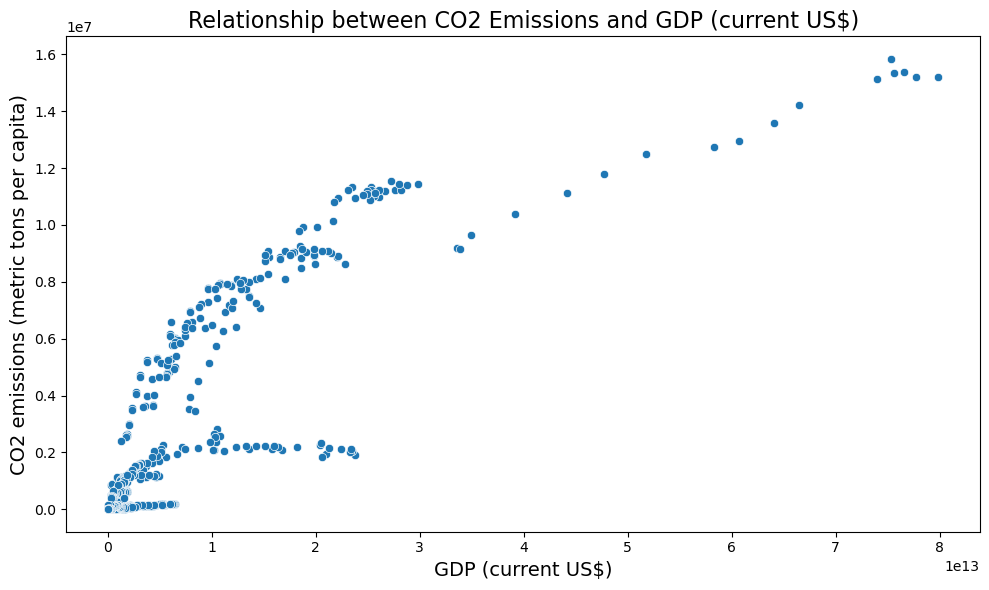

In [11]:


# Establecer el estilo de Seaborn
sns.set_theme=("whitegrid")

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GDP (current US$)', y='CO2 emissions from solid fuel consumption (kt)', data=final_df)

# Establecer escala logarítmica en el eje X si los datos están muy dispersos
#plt.xscale('log')

# Agregar títulos y etiquetas
plt.title('Relationship between CO2 Emissions and GDP (current US$)', fontsize=16)
plt.xlabel('GDP (current US$)', fontsize=14)
plt.ylabel('CO2 emissions (metric tons per capita)', fontsize=14)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

El gráfico indica una relación positiva notable entre el PIB y las emisiones de CO2 per cápita. Esto sugiere que a medida que un país se vuelve económicamente más fuerte y su PIB crece, sus emisiones de CO2 también tienden a aumentar. Este hallazgo es consistente con la hipótesis de que el desarrollo económico está asociado con un mayor consumo de energía y, en consecuencia, con mayores emisiones de gases de efecto invernadero.


In [59]:
from scipy.stats import pearsonr
corr_coefficient, p_value = pearsonr(final_df['GDP (current US$)'], final_df['CO2 emissions from solid fuel consumption (kt)'])
print(corr_coefficient, p_value)

0.8553323998571283 3.7438230204117324e-308


Los resultados indican una relación positiva fuerte entre el PIB y las emisiones de CO2 provenientes del consumo de combustibles sólidos.
Confirmando nuestro argumento pasado

In [60]:
# Sustituir la columna 'Literacy rate, adult total (% of people ages 15 and above)' en el DataFrame original
final_df['Literacy rate, adult total (% of people ages 15 and above)'] = df_selected2['Literacy rate, adult total (% of people ages 15 and above)']


In [61]:
# Sustituir la columna 'Renewable energy consumption (% of total final energy consumption)' en el DataFrame original
final_df['Renewable energy consumption (% of total final energy consumption)'] = df_selected['Renewable energy consumption (% of total final energy consumption)']


Sustituimos las variables clonadas y limpiadas en nuestro dataset original

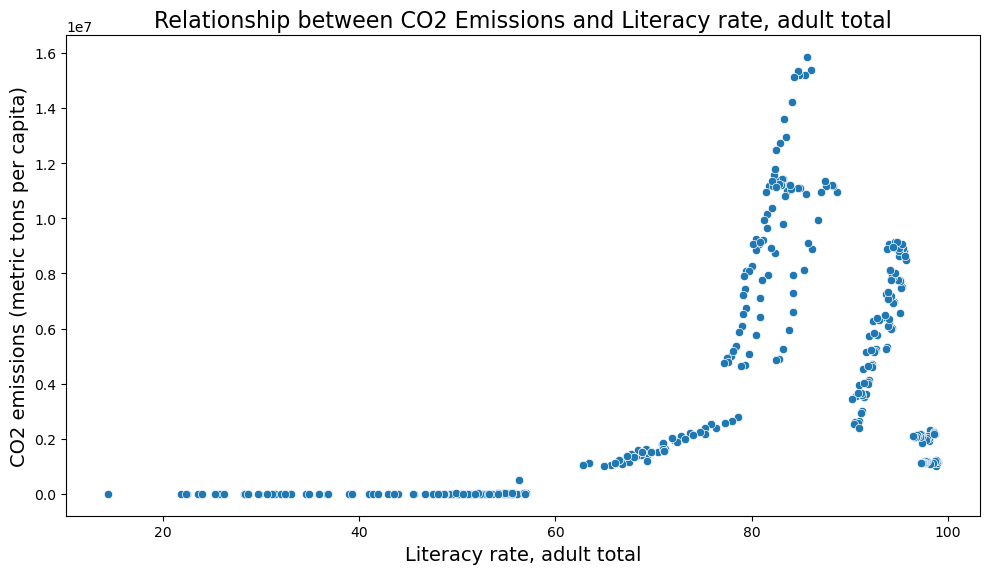

In [62]:

# Establecer el estilo de Seaborn
sns.set_theme=("whitegrid")

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Literacy rate, adult total (% of people ages 15 and above)', y='CO2 emissions from solid fuel consumption (kt)', data=final_df)

# Establecer escala logarítmica en el eje X si los datos están muy dispersos
#plt.xscale('log')

# Agregar títulos y etiquetas
plt.title('Relationship between CO2 Emissions and Literacy rate, adult total', fontsize=16)
plt.xlabel('Literacy rate, adult total', fontsize=14)
plt.ylabel('CO2 emissions (metric tons per capita)', fontsize=14)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Observamos que los cambios en la limpieza estan presentes en el dataset original

In [63]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1073 entries, 4 to 5574
Data columns (total 6 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Country                                                             1073 non-null   object 
 1   Year                                                                1073 non-null   int32  
 2   Renewable energy consumption (% of total final energy consumption)  597 non-null    float64
 3   CO2 emissions from solid fuel consumption (kt)                      1073 non-null   float64
 4   Literacy rate, adult total (% of people ages 15 and above)          363 non-null    float64
 5   GDP (current US$)                                                   1073 non-null   float64
dtypes: float64(4), int32(1), object(1)
memory usage: 54.5+ KB


In [68]:
# Seleccionar solo las columnas numéricas
numeric_df = final_df.select_dtypes(include=[np.number])

# Calcular la correlación entre las columnas numéricas
numeric_df.corr()



,Year,Renewable energy consumption (% of total final energy consumption),CO2 emissions from solid fuel consumption (kt),"Literacy rate, adult total (% of people ages 15 and above)",GDP (current US$)
Year,1.000000,-0.070809,0.071028,0.084292,0.123615
Renewable energy consumption (% of total final energy consumption),-0.070809,1.000000,-0.698087,-0.930631,-0.567265
CO2 emissions from solid fuel consumption (kt),0.071028,-0.698087,1.000000,0.580135,0.855332
"Literacy rate, adult total (% of people ages 15 and above)",0.084292,-0.930631,0.580135,1.000000,0.423843
GDP (current US$),0.123615,-0.567265,0.855332,0.423843,1.000000


In [70]:
corr_matrix = numeric_df.corr()
corr_matrix['CO2 emissions from solid fuel consumption (kt)'].sort_values(ascending=False)

CO2 emissions from solid fuel consumption (kt)                        1.000000
GDP (current US$)                                                     0.855332
Literacy rate, adult total (% of people ages 15 and above)            0.580135
Year                                                                  0.071028
Renewable energy consumption (% of total final energy consumption)   -0.698087
Name: CO2 emissions from solid fuel consumption (kt), dtype: float64

Observamos las correlaciones más fuertes para con la variable de CO2

In [ ]:
# Eliminar la columna 'Year' del DataFrame final_df
final_df = final_df.drop(columns=['Year'])

# Verificar el DataFrame después de eliminar la columna


In [74]:
final_df = final_df.drop(columns=['Country'])

In [75]:
final_df.head()

,Renewable energy consumption (% of total final energy consumption),CO2 emissions from solid fuel consumption (kt),"Literacy rate, adult total (% of people ages 15 and above)",GDP (current US$)
4,62.457688,605867.346840,NaN,8.298300e+11
5,62.128338,587353.836150,NaN,8.992957e+11
6,61.499577,626313.761249,NaN,9.796897e+11
7,61.082685,593205.503573,NaN,9.633473e+11
8,61.718397,594031.621327,NaN,9.526756e+11


Eliminamos columnas no necesarias

In [2]:


# Leer el archivo CSV
df = pd.read_csv('final_df.csv')

# Mostrar las primeras filas del DataFrame
df.head()


,Renewable energy consumption (% of total final energy consumption),CO2 emissions from solid fuel consumption (kt),"Literacy rate, adult total (% of people ages 15 and above)",GDP (current US$)
0,62.457688,605867.346840,NaN,8.298300e+11
1,62.128338,587353.836150,NaN,8.992957e+11
2,61.499577,626313.761249,NaN,9.796897e+11
3,61.082685,593205.503573,NaN,9.633473e+11
4,61.718397,594031.621327,NaN,9.526756e+11


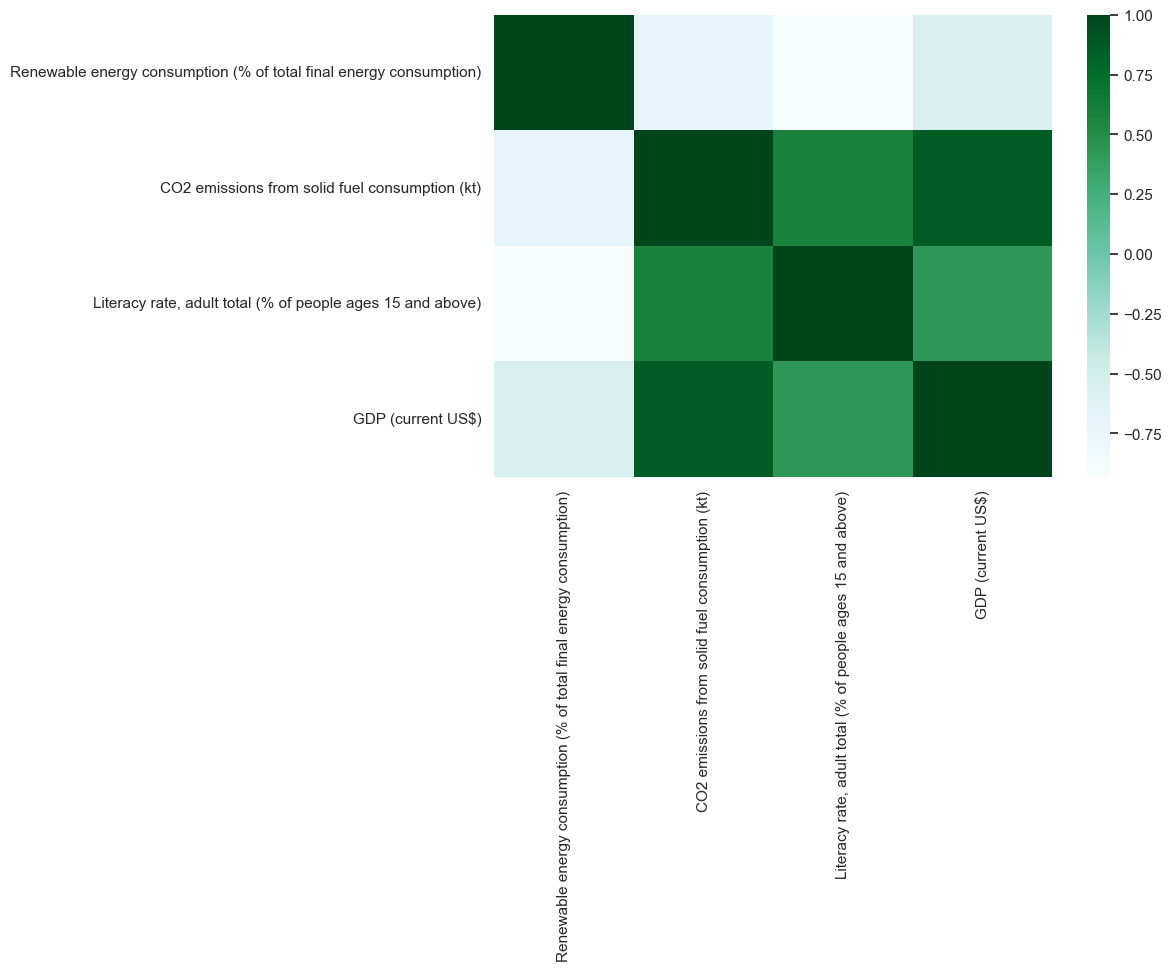

In [4]:
sns.set(rc={'figure.figsize':(9,6)}) 

#########################################################################
# INICIA LA SECCIÓN PARA AGREGAR CÓDIGO.
# Ejercicio 1
# Sustituye "None" por tus líneas de código dentro de esta región.
# Se esperan cuando mucho 2 líneas de código.
b=df.corr(method='pearson')
ax= sns.heatmap(b, cmap="BuGn")


# TERMINA LA SECCIÓN PARA AGREGAR CÓDIGO.
#################

Observamos la matriz de correlación de forma visual

In [21]:
display(df)

,Renewable energy consumption (% of total final energy consumption),CO2 emissions from solid fuel consumption (kt),"Literacy rate, adult total (% of people ages 15 and above)",GDP (current US$)
0,62.457688,605867.346840,NaN,8.298300e+11
1,62.128338,587353.836150,NaN,8.992957e+11
2,61.499577,626313.761249,NaN,9.796897e+11
3,61.082685,593205.503573,NaN,9.633473e+11
4,61.718397,594031.621327,NaN,9.526756e+11
...,...,...,...,...
1068,89.200000,381.368000,NaN,2.026556e+10
1069,90.700000,293.360000,NaN,1.405696e+10
1070,89.600000,304.361000,NaN,4.193850e+09
1071,80.800000,7737.370000,NaN,1.949552e+10


In [7]:
df.columns

Index(['Renewable energy consumption (% of total final energy consumption)',
       'CO2 emissions from solid fuel consumption (kt)',
       'Literacy rate, adult total (% of people ages 15 and above)',
       'GDP (current US$)'],
      dtype='object')

## Entrenamiento Modelo de regresión lineal

En este punto del anális, quitare todos los valores nan del dataset para el entrenamiento del modelo

In [22]:

# Remover filas que contienen valores nulos
final_df_cleaned = df.dropna()

# Opcional: Verifica la nueva dimensionalidad del DataFrame
final_df_cleaned.info()



<class 'pandas.core.frame.DataFrame'>
Index: 351 entries, 17 to 1000
Data columns (total 4 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Renewable energy consumption (% of total final energy consumption)  351 non-null    float64
 1   CO2 emissions from solid fuel consumption (kt)                      351 non-null    float64
 2   Literacy rate, adult total (% of people ages 15 and above)          351 non-null    float64
 3   GDP (current US$)                                                   351 non-null    float64
dtypes: float64(4)
memory usage: 13.7 KB


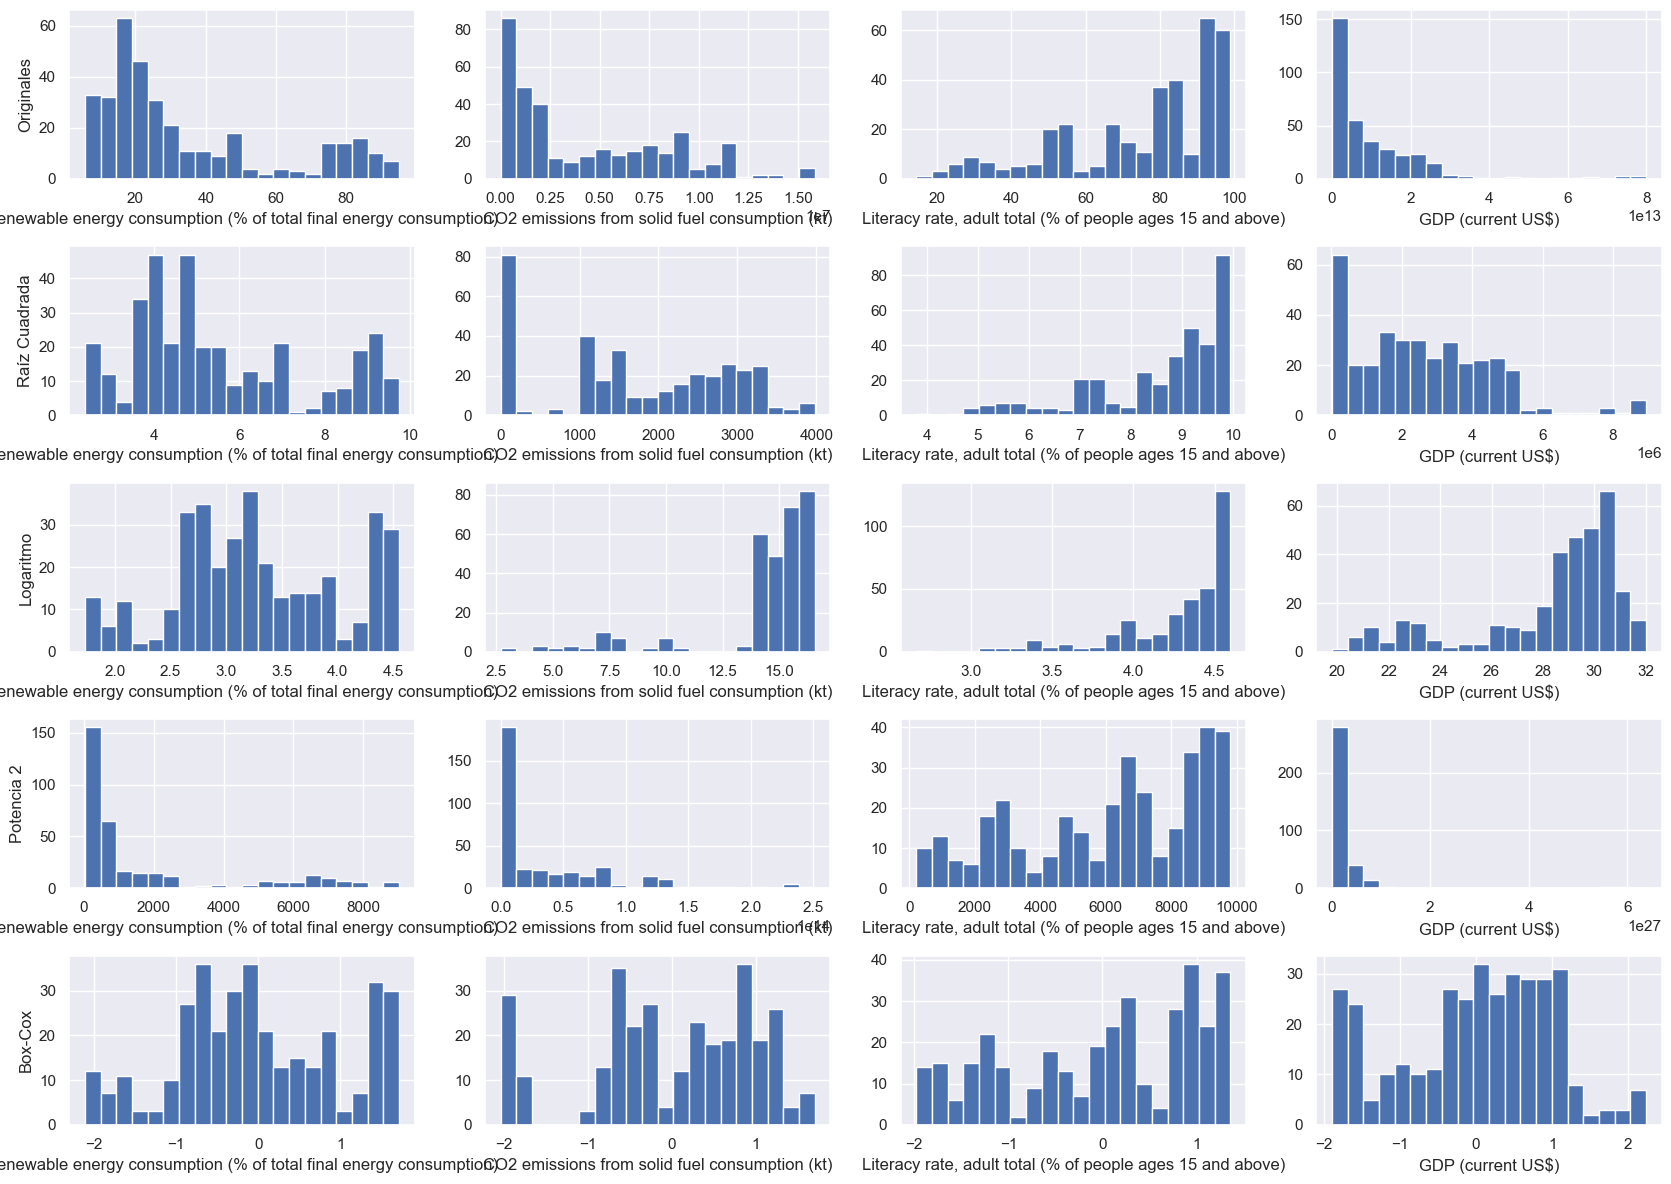

In [30]:


variables_a_transformar = ['Renewable energy consumption (% of total final energy consumption)',
       'CO2 emissions from solid fuel consumption (kt)',
       'Literacy rate, adult total (% of people ages 15 and above)',
       'GDP (current US$)']

sns.set(rc={'figure.figsize':(17,12)})
fig, axes = plt.subplots(5, len(variables_a_transformar))    
  
for k in range(len(variables_a_transformar)):       
 
    # Datos originales ---------------------------------------------------------
    plt.subplot(5, len(variables_a_transformar), k+1) 

    Transf0 = final_df_cleaned[variables_a_transformar[k]]          
    plt.hist(Transf0, bins=20)                    

    plt.xlabel(variables_a_transformar[k])
    if k==0:
      plt.ylabel('Originales')

    # Datos transformados con raíz cuadrada ------------------------------------
    plt.subplot(5, len(variables_a_transformar), k+1 + len(variables_a_transformar))    

    Transf1 = np.sqrt(Transf0)          
    plt.hist(Transf1, bins=20)                    

    plt.xlabel(variables_a_transformar[k])
    if k==0:
      plt.ylabel('Raíz Cuadrada')
    
    # Datos transformados con logaritmo natural --------------------------------
    plt.subplot(5, len(variables_a_transformar), k+1 + 2*len(variables_a_transformar))     

    # Filtrar valores <= 0 para evitar problemas con logaritmo
    Transf2 = np.log(Transf0[Transf0 > 0])          
    plt.hist(Transf2, bins=20)                    

    plt.xlabel(variables_a_transformar[k])
    if k==0:
      plt.ylabel('Logaritmo')
    
    # Datos transformados con la potencia de 2 ---------------------------------
    plt.subplot(5, len(variables_a_transformar), k+1 + 3*len(variables_a_transformar))

    Transf3 = np.square(Transf0)          
    plt.hist(Transf3, bins=20)                    

    plt.xlabel(variables_a_transformar[k])
    if k==0:
      plt.ylabel('Potencia 2')
    
    # Datos transformados con Box-Cox ------------------------------------------
    plt.subplot(5, len(variables_a_transformar), k+1 + 4*len(variables_a_transformar))

    # Filtrar valores <= 0 para Box-Cox, ya que requiere datos estrictamente positivos
    Transf4 = power_transform(np.array(Transf0[Transf0 > 0]).reshape(-1,1), method="box-cox")         
    plt.hist(Transf4, bins=20)                    

    plt.xlabel(variables_a_transformar[k])
    if k==0:
      plt.ylabel('Box-Cox')

plt.tight_layout()
plt.show()




Realizamos diferentes transformaciónes a las distribuciones de las variables

In [47]:

# Declaramos nuestra columna objetivo:
columna_objetivo = 'CO2 emissions from solid fuel consumption (kt)'

# Matriz con features:
X = final_df_cleaned.drop(columna_objetivo, axis=1)

# Matriz objetivo:
y = final_df_cleaned[[columna_objetivo]]


# Creamos los conjuntos de entrenamiento y prueba:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)

print(f"""
┌────────────────────────────────────────────────────────┐
│Crear conjuntos de entrenamiento y prueba:              │
└────────────────────────────────────────────────────────┘

> Tamaño de variables de entrenamiento: {X_train.shape} || tamaño de objetivo entrenamiento: {y_train.shape}
> Tamaño de variables de prueba: {X_test.shape} || tamaño de objetivo prueba: {y_test.shape}
""")


┌────────────────────────────────────────────────────────┐
│Crear conjuntos de entrenamiento y prueba:              │
└────────────────────────────────────────────────────────┘

> Tamaño de variables de entrenamiento: (298, 3) || tamaño de objetivo entrenamiento: (298, 1)
> Tamaño de variables de prueba: (53, 3) || tamaño de objetivo prueba: (53, 1)



Dividimos en entrenamiento y testeo 

In [59]:


# Definir los pipelines individualmente para cada transformación
pipeline_original = Pipeline(steps=[
    ('scaler', StandardScaler())  # Escalado sin transformación adicional
])

pipeline_sqrt = Pipeline(steps=[
    ('sqrt', FunctionTransformer(func=np.sqrt)), 
    ('scaler', StandardScaler())
])

pipeline_log = Pipeline(steps=[
    ('log', FunctionTransformer(func=np.log1p)), 
    ('scaler', StandardScaler())
])

pipeline_square = Pipeline(steps=[
    ('square', FunctionTransformer(func=np.square)), 
    ('scaler', StandardScaler())
])

pipeline_boxcox = Pipeline(steps=[
    ('boxcox', PowerTransformer(method='box-cox')), 
    ('scaler', StandardScaler())
])

# Columnas a transformar
transform_columns = ['Renewable energy consumption (% of total final energy consumption)',
                     'Literacy rate, adult total (% of people ages 15 and above)',
                     'GDP (current US$)']

# Aplicar cada pipeline de forma individual para generar diferentes datasets
X_original = pipeline_original.fit_transform(X_train[transform_columns])
X_sqrt = pipeline_sqrt.fit_transform(X_train[transform_columns])
X_log = pipeline_log.fit_transform(X_train[transform_columns])
X_square = pipeline_square.fit_transform(X_train[transform_columns])
X_boxcox = pipeline_boxcox.fit_transform(X_train[transform_columns])

# Convertir los resultados a DataFrames para facilitar su manejo
X_original_df = pd.DataFrame(X_original, columns=transform_columns)
X_sqrt_df = pd.DataFrame(X_sqrt, columns=transform_columns)
X_log_df = pd.DataFrame(X_log, columns=transform_columns)
X_square_df = pd.DataFrame(X_square, columns=transform_columns)
X_boxcox_df = pd.DataFrame(X_boxcox, columns=transform_columns)

# Ahora tienes cinco datasets diferentes
datasets = {
    'original': X_original_df,
    'sqrt': X_sqrt_df,
    'log': X_log_df,
    'square': X_square_df,
    'boxcox': X_boxcox_df
}

# Ejemplo de cómo utilizar uno de los datasets con tu modelo
pipeline_model = Pipeline(steps=[('model', LinearRegression())])

# Evaluar el modelo usando, por ejemplo, el dataset con la transformación de raíz cuadrada
X_transformed = datasets['sqrt']
pipeline_model.fit(X_transformed, y_train)

# Puedes realizar evaluaciones similares con cada uno de los datasets





Pipeline(steps=[('model', LinearRegression())])

Creación de pipeline con diferentes transformaciónes con el fin de elegir la transformación que más nos permita obtener un mejor metrico de validación

Evaluando dataset: original
     
                ---- Regresión Lineal en original ----  
                mean RMSE:  2196839.053 (112856.0788)
                mean R²: 0.706 (0.0463)
                
Evaluando dataset: sqrt
     
                ---- Regresión Lineal en sqrt ----  
                mean RMSE:  1873615.633 (180851.8709)
                mean R²: 0.783 (0.0598)
                
Evaluando dataset: log
     
                ---- Regresión Lineal en log ----  
                mean RMSE:  2870988.977 (192173.6217)
                mean R²: 0.501 (0.0608)
                
Evaluando dataset: square
     
                ---- Regresión Lineal en square ----  
                mean RMSE:  2655775.596 (165743.0043)
                mean R²: 0.572 (0.0520)
                
Evaluando dataset: boxcox
     
                ---- Regresión Lineal en boxcox ----  
                mean RMSE:  2019470.607 (167098.2036)
                mean R²: 0.749 (0.0564)
                


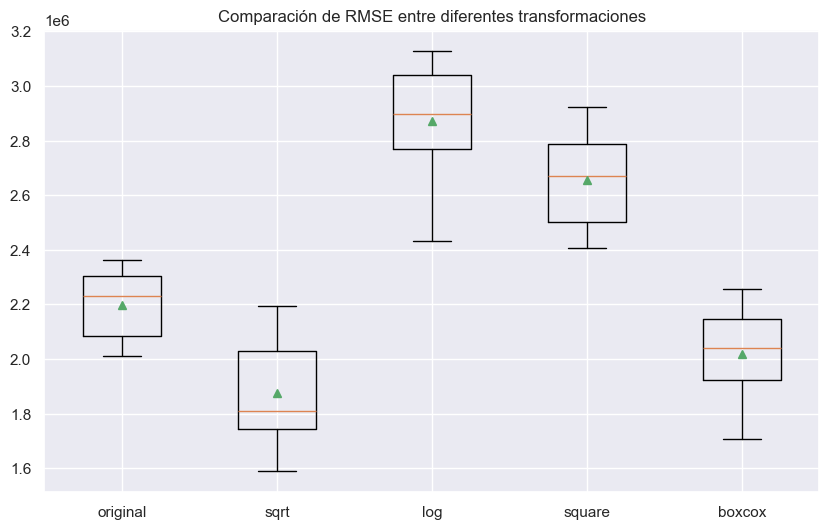

In [60]:


# Definir los modelos a utilizar
modelos = [
    ('Regresión Lineal', LinearRegression())
]

# Definimos las métricas para un problema de regresión
def get_rmse(yreal, ypred):
    return np.sqrt(mean_squared_error(yreal, ypred))

# Diccionario con métricas a revisar
metricas = { 
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'r2': 'r2',
    'rmse': make_scorer(get_rmse, greater_is_better=True)
}

# Parámetros de validación cruzada
kfold = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# Función para correr los modelos en diferentes datasets
def correr_modelos_por_dataset(datasets, verbose=True):
    resultados_por_dataset = {}
    
    for nombre_dataset, X_transformed in datasets.items():
        print(f"Evaluando dataset: {nombre_dataset}")

        # Donde guardar los resultados
        resultados = list()
        
        # Iteramos sobre cada modelo
        for i in range(len(modelos)):  
            pipeline = Pipeline(steps=[
                ('mo', modelos[i][1]),
            ])

            # Entrenamos con cross_validate sobre nuestro k-fold decidido y para las métricas que corrimos
            resultados_modelo = cross_validate(pipeline, X_transformed, y_train, scoring=metricas, cv=kfold)
            
            # Capturamos los resultados
            resultados.append(resultados_modelo)

            # Expresamos los resultados si el usuario deja verbose
            if(verbose):
                print(f"""     
                ---- {modelos[i][0]} en {nombre_dataset} ----  
                mean RMSE:  {np.mean(resultados_modelo['test_rmse']):.3f} ({np.std(resultados_modelo['test_rmse']):.4f})
                mean R²: {np.mean(resultados_modelo['test_r2']):.3f} ({np.std(resultados_modelo['test_r2']):.4f})
                """
                )

        resultados_por_dataset[nombre_dataset] = resultados

    return resultados_por_dataset

# Evaluamos los modelos en cada dataset
resultados = correr_modelos_por_dataset(datasets)

# Graficar boxplots para los diferentes datasets (opcional para alguna métrica en particular, como RMSE)
sns.set(rc={'figure.figsize':(10,6)})
bp = {}

for nombre_dataset, resultados_dataset in resultados.items():
    for i in range(len(resultados_dataset)):
        rr = resultados_dataset[i]['test_rmse']
        bp[nombre_dataset] = rr

# Crear un boxplot por cada dataset
plt.boxplot(bp.values(), labels=bp.keys(), showmeans=True)
plt.title("Comparación de RMSE entre diferentes transformaciones")
plt.show()


El modelo de regresión lineal aplicado al conjunto de datos transformado con sqrt mostró el mejor rendimiento general, con el menor RMSE y el mayor R². Esto sugiere que la aplicación de una raíz cuadrada a las variables en este caso mejora significativamente la capacidad del modelo para ajustar los datos y explicar la variabilidad en la variable dependiente.
Esto seguido de la transfroamcion boxcox

 
    ┌────────────────────────────────────────────────────────┐
    │Ejercicio 4.e.i - Aprendizaje en Regresión Lineal (original) │
    └────────────────────────────────────────────────────────┘
    


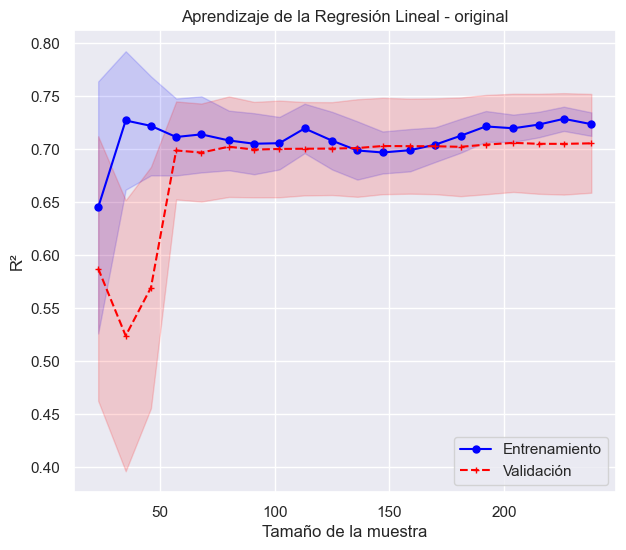

 
    ┌────────────────────────────────────────────────────────┐
    │Ejercicio 4.e.i - Aprendizaje en Regresión Lineal (sqrt) │
    └────────────────────────────────────────────────────────┘
    


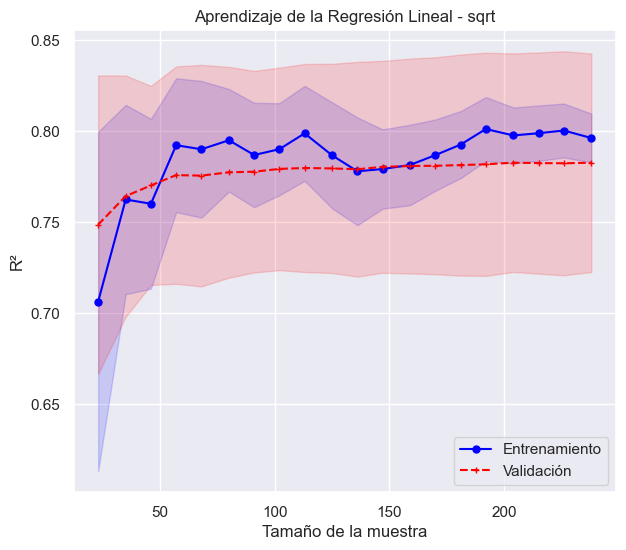

 
    ┌────────────────────────────────────────────────────────┐
    │Ejercicio 4.e.i - Aprendizaje en Regresión Lineal (log) │
    └────────────────────────────────────────────────────────┘
    


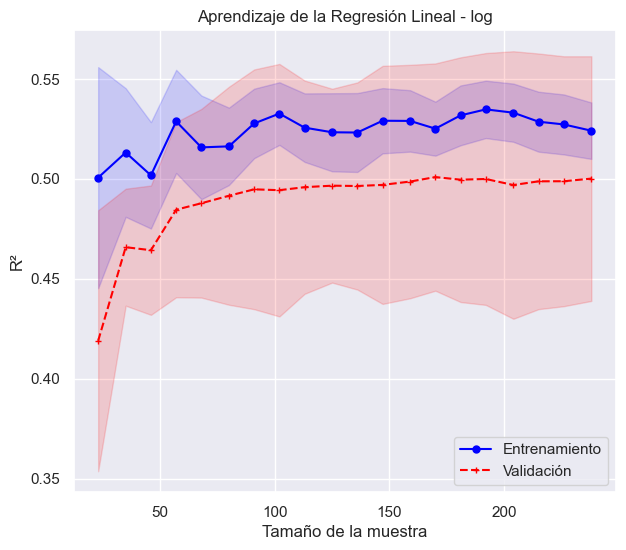

 
    ┌────────────────────────────────────────────────────────┐
    │Ejercicio 4.e.i - Aprendizaje en Regresión Lineal (square) │
    └────────────────────────────────────────────────────────┘
    


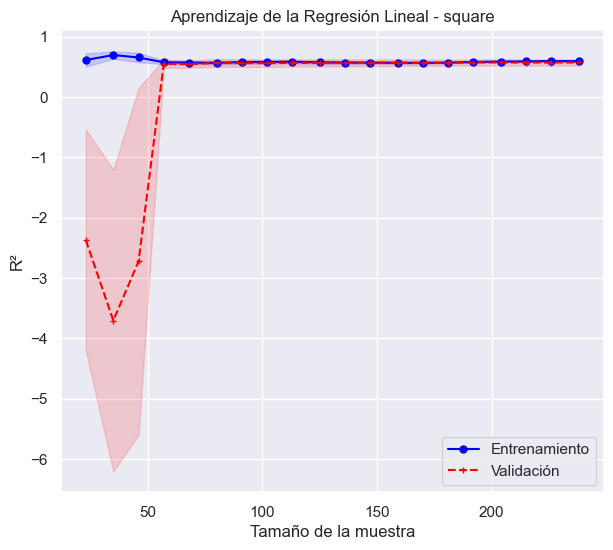

 
    ┌────────────────────────────────────────────────────────┐
    │Ejercicio 4.e.i - Aprendizaje en Regresión Lineal (boxcox) │
    └────────────────────────────────────────────────────────┘
    


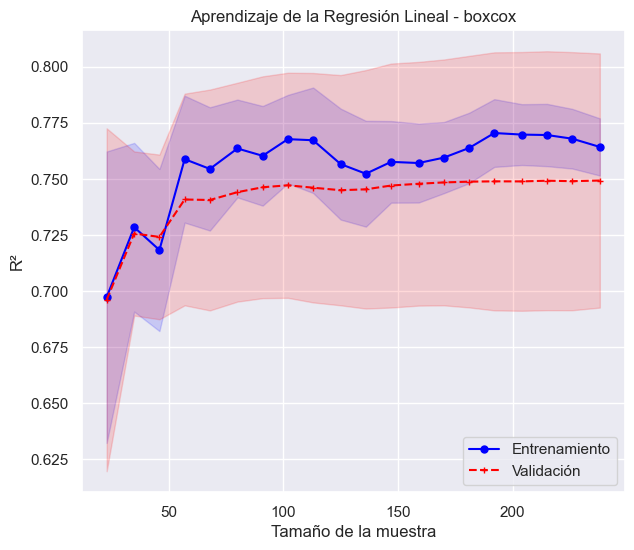

In [61]:

# Usar R² como métrica
scoring = make_scorer(r2_score)

# En un espacio de 20 muestras
delta_train = np.linspace(0.1, 1.0, 20)

# Función para graficar la curva de aprendizaje
def plot_LearningCurve(train_sizes, train_scores, val_scores, labels={'title':'', 'xlabel':'', 'ylabel':''}):

    # Obtenemos los promedios y desviaciones estándar de cada renglón de los resultados de entrenamiento y validación
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Inicializar el plot
    plt.figure(figsize=(7,6))

    # Graficamos las curvas de aprendizaje incluyendo una región indicando la desviación estándar.    
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Entrenamiento')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    
    # Graficamos las curvas de validación incluyendo una región indicando la desviación estándar.
    plt.plot(train_sizes, val_mean, color='red', marker='+', markersize=5, linestyle='--', label='Validación')
    plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.15, color='red')

    # Agregamos etiquetas
    plt.title(labels['title'])
    plt.xlabel(labels['xlabel'])
    plt.ylabel(labels['ylabel'])
    plt.legend(loc='lower right')
    plt.grid(True, which='both')
    plt.show()

# Iterar sobre cada dataset transformado
for nombre_dataset, X_transformed in datasets.items():
    
    # Definir el pipeline con el modelo de regresión lineal
    pipeline = Pipeline(steps=[('mo', LinearRegression())])
    
    # Obtener los datos de entrenamiento y validación
    tr_sizes, tr_scores, val_scores = learning_curve(
        estimator=pipeline,
        X=X_transformed,
        y=y_train,
        cv=kfold,
        train_sizes=delta_train,
        scoring=scoring,
        n_jobs=-1
    )

    # Etiquetas para las gráficas
    labels = { 
        'title': f'Aprendizaje de la Regresión Lineal - {nombre_dataset}',
        'xlabel': 'Tamaño de la muestra',
        'ylabel': 'R²'
    }

    print(f""" 
    ┌────────────────────────────────────────────────────────┐
    │Ejercicio 4.e.i - Aprendizaje en Regresión Lineal ({nombre_dataset}) │
    └────────────────────────────────────────────────────────┘
    """)

    # Graficar la curva de aprendizaje
    plot_LearningCurve(tr_sizes, tr_scores, val_scores, labels)


Elegimos boxcox dada al comportamiento del aprendizaje, no llega a sobreentrenarse o a subentrenarse por lo que elegire este, podríamos obtener un resultado parectido con la sqrt

### Fine Tunning

In [63]:

# Definir el modelo a utilizar
modelo = LinearRegression()

# Definir el rango de parámetros para la búsqueda
parameter_fit_intercept = [True, False]
parameter_positive = [True, False]

# Definir el diccionario para búsqueda en GridSearchCV
dict_grid = {
    'fit_intercept': parameter_fit_intercept,
    'positive': parameter_positive
}

# Usar R² como métrica para la regresión
scoring = make_scorer(r2_score)

# Definir la validación cruzada
kfold = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# Definir grid search
grid_RL = GridSearchCV(
    estimator=modelo,
    param_grid=dict_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1
)

# Utilizar el dataset transformado con Box-Cox
Xx = datasets['boxcox']
Yy = np.ravel(y_train)

# Entrenar sobre los datos objetivo
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="One or more of the test scores are non-finite")
    grid_RL.fit(Xx, Yy)

print(f""" 
┌────────────────────────────────────────────────────────┐
│Mejores parámetros Regresión Lineal      │
└────────────────────────────────────────────────────────┘
""")

# Obtenemos resultados
print('Mejor combinación de valores encontrados de los hiperparámetros:', grid_RL.best_params_)
print('Métrica utilizada:', grid_RL.scoring)
print('Mejor valor obtenido con la mejor combinación:', grid_RL.best_score_)



 
┌────────────────────────────────────────────────────────┐
│Mejores parámetros Regresión Lineal      │
└────────────────────────────────────────────────────────┘

Mejor combinación de valores encontrados de los hiperparámetros: {'fit_intercept': True, 'positive': True}
Métrica utilizada: make_scorer(r2_score, response_method='predict')
Mejor valor obtenido con la mejor combinación: 0.7494200882497475


Obtenemos los mejores parametros para el modelo

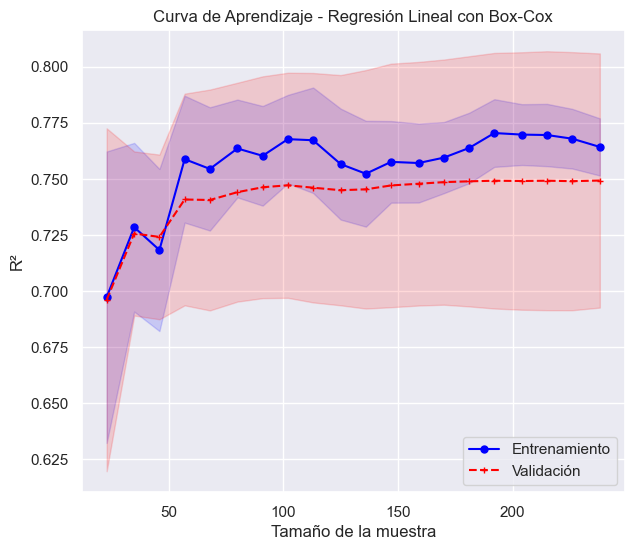

In [64]:


# Definir el modelo de regresión lineal con los mejores parámetros
mejor_modelo = LinearRegression(fit_intercept=True, positive=True)

# Definir el pipeline con el mejor modelo
pipeline = Pipeline(steps=[('mo', mejor_modelo)])

# En un espacio de 20 de muestras
delta_train = np.linspace(0.1, 1.0, 20)

# Usar R² como métrica
scoring = make_scorer(r2_score)

# Obtener los datos de entrenamiento y validación utilizando la curva de aprendizaje
tr_sizes, tr_scores, val_scores = learning_curve(
    estimator=pipeline,
    X=datasets['boxcox'],  # Usando el dataset transformado con Box-Cox
    y=y_train,
    cv=kfold,
    train_sizes=delta_train,
    scoring=scoring,
    n_jobs=-1
)

# Etiquetas para las gráficas
labels = { 
    'title': 'Curva de Aprendizaje - Regresión Lineal con Box-Cox',
    'xlabel': 'Tamaño de la muestra',
    'ylabel': 'R²'
}

# Función para graficar la curva de aprendizaje
def plot_LearningCurve(train_sizes, train_scores, val_scores, labels={'title':'', 'xlabel':'', 'ylabel':''}):

    # Obtenemos los promedios y desviaciones estándar de cada renglón de los resultados de entrenamiento y validación
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Inicializar el plot
    plt.figure(figsize=(7,6))

    # Graficamos las curvas de aprendizaje incluyendo una región indicando la desviación estándar.    
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Entrenamiento')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    
    # Graficamos las curvas de validación incluyendo una región indicando la desviación estándar.
    plt.plot(train_sizes, val_mean, color='red', marker='+', markersize=5, linestyle='--', label='Validación')
    plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.15, color='red')

    # Agregamos etiquetas
    plt.title(labels['title'])
    plt.xlabel(labels['xlabel'])
    plt.ylabel(labels['ylabel'])
    plt.legend(loc='lower right')
    plt.grid(True, which='both')
    plt.show()

# Graficar la curva de aprendizaje con los mejores parámetros
plot_LearningCurve(tr_sizes, tr_scores, val_scores, labels)


Curva de aprendizaje con los mejores parametros segun el gridsearch

In [65]:


# Asumiendo que tus datos están en X y y
# X = <tu_dataframe_de_características>
# y = <tu_variable_objetivo>

# Paso 1: Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Paso 2: Definir la transformación Box-Cox y el modelo con los mejores parámetros
transform_columns = ['Renewable energy consumption (% of total final energy consumption)',
                     'Literacy rate, adult total (% of people ages 15 and above)',
                     'GDP (current US$)']

# Pipeline para aplicar la transformación Box-Cox
pipeline_boxcox = Pipeline(steps=[
    ('boxcox', PowerTransformer(method='box-cox')), 
    ('scaler', StandardScaler())
])

# Aplicar la transformación solo a las columnas seleccionadas
columnasTransformer = ColumnTransformer(transformers=[
    ('boxcox', pipeline_boxcox, transform_columns)
])

# Definir el modelo con los mejores parámetros
modelo = LinearRegression(fit_intercept=True, positive=True)

# Crear el pipeline completo
pipeline_model = Pipeline(steps=[
    ('transformer', columnasTransformer),
    ('modelo', modelo)
])

# Paso 3: Definir la validación cruzada
kfold = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# Paso 4: Entrenar y evaluar el modelo usando cross_validate con R²
scoring = make_scorer(r2_score)
resultados = cross_validate(pipeline_model, X_train, y_train, cv=kfold, scoring=scoring, return_train_score=True)

# Imprimir los resultados de la validación cruzada
print(f"Resultados de la validación cruzada:")
print(f"R² promedio en entrenamiento: {np.mean(resultados['train_score']):.4f}")
print(f"R² promedio en validación: {np.mean(resultados['test_score']):.4f}")

# Paso 5: Entrenar el modelo final usando todos los datos de entrenamiento y guardarlo
pipeline_model.fit(X_train, y_train)

# Guardar el modelo entrenado para su uso futuro
joblib.dump(pipeline_model, 'modelo_regresion_lineal_boxcox.pkl')

print("Modelo guardado como 'modelo_regresion_lineal_boxcox.pkl'")


Resultados de la validación cruzada:
R² promedio en entrenamiento: 0.7639
R² promedio en validación: 0.7508
Modelo guardado como 'modelo_regresion_lineal_boxcox.pkl'


El modelo de regresión lineal aplicado con la transformación Box-Cox ha demostrado ser robusto, con un desempeño consistente tanto en entrenamiento como en validación. Los valores de R² cercanos entre sí indican que el modelo tiene una buena capacidad predictiva sin caer en el sobreajuste, lo que sugiere que está bien preparado para hacer predicciones en datos no vistos.

## Prueba del modelo mediante escenario

In [74]:

# Step 1: Load the trained model
model = joblib.load('modelo_regresion_lineal_boxcox.pkl')

# Step 2: Select a data point and simulate a 5% increase in GDP
data_point = X_test.iloc[0].copy()

# Save the original data point for comparison
original_data_point = data_point.copy()

# Simulate the 5% GDP increase
data_point['GDP (current US$)'] *= 1.05

# Step 3: Ensure the data point is in the correct format (DataFrame) for prediction
data_point_df = pd.DataFrame([data_point])
original_data_point_df = pd.DataFrame([original_data_point])

# Step 4: Predict CO2 emissions before the GDP increase
original_co2_emissions = model.predict(original_data_point_df)

# Predict CO2 emissions after the GDP increase
predicted_co2_emissions = model.predict(data_point_df)

# Step 5: Calculate the difference in CO2 emissions
change_in_co2 = predicted_co2_emissions[0] - original_co2_emissions[0]

# Step 6: Ensure the result is a scalar and print it
original_co2_value = original_co2_emissions.item()
predicted_co2_value = predicted_co2_emissions.item()
change_in_co2_value = change_in_co2.item()

print(f"Original CO2 Emissions: {original_co2_value:.4f}")
print(f"Predicted CO2 Emissions after 5% GDP increase: {predicted_co2_value:.4f}")
print(f"Change in CO2 Emissions: {change_in_co2_value:.4f}")




Original CO2 Emissions: 7061180.2668
Predicted CO2 Emissions after 5% GDP increase: 7222083.3956
Change in CO2 Emissions: 160903.1288


Los resultados muestran un crecimiento conservador, no se observan respuestas poco razonables, deberíamos de evaluar con algun especialiasta en el área para validar esta predicción